In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
# np.random.seed(42)

# Path to CSV
csv_path = '../data_files/dehum_data_explicit.csv'

# Try different encodings
encodings_to_try = ['utf-8', 'utf-8-sig', 'latin-1', 'cp1252', 'iso-8859-1']

df = None
for encoding in encodings_to_try:
    try:
        print(f"Trying encoding: {encoding}")
        df = pd.read_csv(csv_path, encoding=encoding, sep=None, engine='python')
        print(f"✓ Success with {encoding}! Loaded {len(df)} rows, {len(df.columns)} columns")
        break
    except Exception as e:
        print(f"✗ Failed with {encoding}: {str(e)[:80]}")
        continue

if df is None:
    raise ValueError("Could not read CSV with any encoding!")

# Clean column names: remove quotes and whitespace
print(f"\nBefore cleaning: {df.columns[:5].tolist()}")
df.columns = df.columns.str.strip().str.strip('"').str.strip("'").str.strip()
print(f"After cleaning: {df.columns[:5].tolist()}")

# Check for exp_dehum_binary column
print(f"\nLooking for 'exp_dehum_binary' column...")
if 'exp_dehum_binary' in df.columns:
    print(f"✓ Found exp_dehum_binary column!")
    label_col = 'exp_dehum_binary'
else:
    # Look for similar columns
    dehum_cols = [c for c in df.columns if 'dehum' in c.lower() and 'binary' in c.lower()]
    if dehum_cols:
        label_col = dehum_cols[0]
        print(f"✓ Using similar column: {label_col}")
    else:
        print(f"Available columns: {df.columns.tolist()}")
        raise ValueError("Could not find dehumanization label column!")

# Convert label column to numeric
df[label_col] = pd.to_numeric(df[label_col], errors='coerce').fillna(0).astype(int)
print(f"\nLabel distribution in full dataset:")
print(df[label_col].value_counts())

Trying encoding: utf-8
✗ Failed with utf-8: 'utf-8' codec can't decode byte 0xfc in position 203: invalid start byte
Trying encoding: utf-8-sig
✗ Failed with utf-8-sig: 'utf-8' codec can't decode byte 0xfc in position 203: invalid start byte
Trying encoding: latin-1
✓ Success with latin-1! Loaded 3855 rows, 14 columns

Before cleaning: ['Column1', 'instance_id', 'displayed_text', 'animal', 'subhuman']
After cleaning: ['Column1', 'instance_id', 'displayed_text', 'animal', 'subhuman']

Looking for 'exp_dehum_binary' column...
✓ Found exp_dehum_binary column!

Label distribution in full dataset:
exp_dehum_binary
0    3163
1     692
Name: count, dtype: int64


In [ ]:
# Sample 200 rows randomly
sample_size = min(200, len(df))
df_sample = df.sample(n=sample_size).reset_index(drop=True)
print(f"\nSampled {sample_size} rows")

# Count labels in sample
counts = df_sample[label_col].value_counts()
labels = ['Dehumanized' if i == 1 else 'Not Dehumanized' for i in counts.index]
values = counts.values

print(f"\nSample distribution:")
for label, value in zip(labels, values):
    pct = (value / sample_size) * 100
    print(f"  {label}: {value} ({pct:.1f}%)")

# Plot
plt.figure(figsize=(8, 5))
colors = ['#d62728' if 'Dehumanized' in l and 'Not' not in l else '#1f77b4' for l in labels]
bars = plt.bar(labels, values, color=colors, edgecolor='black', linewidth=1.2)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}\n({height/sample_size*100:.1f}%)',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.title(f'Dehumanization Distribution in Random Sample (n={sample_size})',
          fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Count', fontsize=12)

plt.xlabel('Label', fontsize=12)
plt.xticks(rotation=0)
plt.ylim(0, max(values) * 1.15)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print(f"\n✓ Done! Sample saved to memory as 'df_sample'")

DATASET DISTRIBUTION ANALYSIS

Full dataset size: 3855 rows

──────────────────────────────────────────────────────────────────────
FULL DATASET DISTRIBUTION:
──────────────────────────────────────────────────────────────────────
  Dehumanized (1):        692 (17.95%)
  Not Dehumanized (0):  3,163 (82.05%)
  ──────────────────────────────────────────────────
  TOTAL:                3,855 (100.00%)

──────────────────────────────────────────────────────────────────────
CONSISTENCY CHECK: Multiple random samples of 200
──────────────────────────────────────────────────────────────────────
  Sample  1:  33/200 dehumanized ( 16.5%)
  Sample  2:  33/200 dehumanized ( 16.5%)
  Sample  3:  34/200 dehumanized ( 17.0%)
  Sample  4:  40/200 dehumanized ( 20.0%)
  Sample  5:  42/200 dehumanized ( 21.0%)
  Sample  6:  35/200 dehumanized ( 17.5%)
  Sample  7:  37/200 dehumanized ( 18.5%)
  Sample  8:  37/200 dehumanized ( 18.5%)
  Sample  9:  38/200 dehumanized ( 19.0%)
  Sample 10:  41/200 dehuman

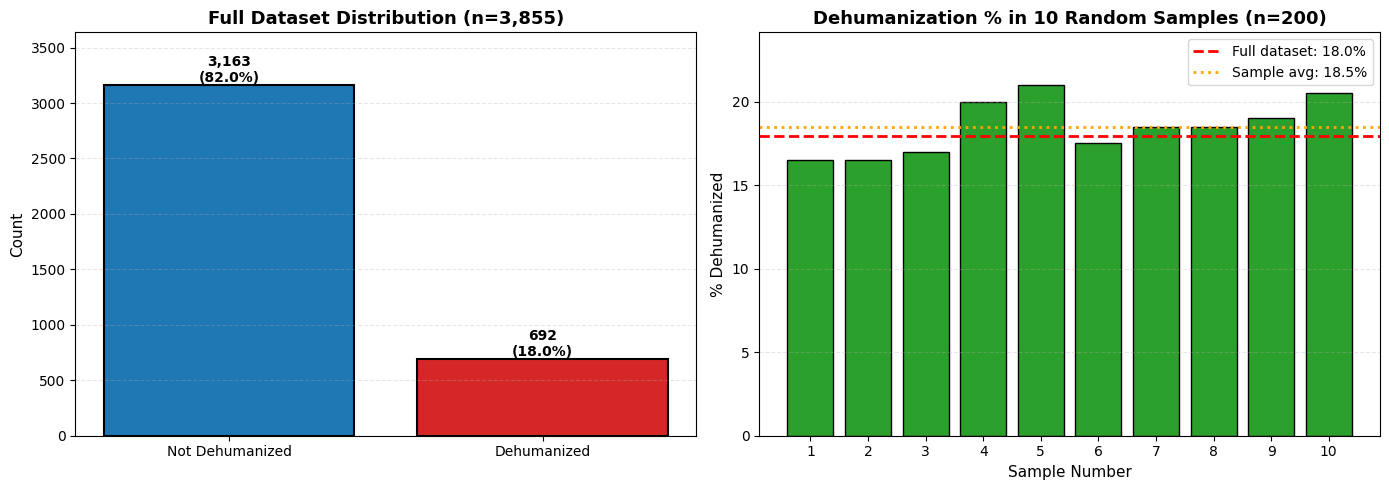


CONCLUSION:
⚠ The full dataset has 18.0% dehumanizing content,
  which differs from the 30/70 split you observed in samples.

  Random sampling is working correctly - samples reflect the
  natural distribution with expected statistical variation.



In [10]:
# ======================================================
# ANALYSIS: Check if 30/70 split is intentional or natural
# ======================================================
import pandas as pd
import matplotlib.pyplot as plt

print("=" * 70)
print("DATASET DISTRIBUTION ANALYSIS")
print("=" * 70)

# Use the df from previous cell (full dataset)
if 'df' in locals() and df is not None:
    print(f"\nFull dataset size: {len(df)} rows")

    # Get label column name
    if 'label_col' in locals():
        col = label_col
    elif 'exp_dehum_binary' in df.columns:
        col = 'exp_dehum_binary'
    else:
        dehum_cols = [c for c in df.columns if 'dehum' in c.lower() and 'binary' in c.lower()]
        col = dehum_cols[0] if dehum_cols else None

    if col:
        # Full dataset distribution
        full_counts = df[col].value_counts().sort_index()
        total = len(df)

        print(f"\n{'─'*70}")
        print("FULL DATASET DISTRIBUTION:")
        print(f"{'─'*70}")
        dehumanized = full_counts.get(1, 0)
        not_dehumanized = full_counts.get(0, 0)

        dehum_pct = (dehumanized / total) * 100
        not_dehum_pct = (not_dehumanized / total) * 100

        print(f"  Dehumanized (1):     {dehumanized:>6,} ({dehum_pct:>5.2f}%)")
        print(f"  Not Dehumanized (0): {not_dehumanized:>6,} ({not_dehum_pct:>5.2f}%)")
        print(f"  {'─'*50}")
        print(f"  TOTAL:               {total:>6,} (100.00%)")

        # Multiple random samples to check consistency
        print(f"\n{'─'*70}")
        print("CONSISTENCY CHECK: Multiple random samples of 200")
        print(f"{'─'*70}")

        sample_results = []
        num_samples = 10
        sample_size = 200

        for i in range(num_samples):
            sample = df.sample(n=min(sample_size, len(df)), random_state=i)
            dehum_in_sample = sample[col].sum()
            pct = (dehum_in_sample / len(sample)) * 100
            sample_results.append(pct)
            print(f"  Sample {i+1:2d}: {dehum_in_sample:3d}/200 dehumanized ({pct:5.1f}%)")

        mean_pct = np.mean(sample_results)
        std_pct = np.std(sample_results)
        print(f"\n  Average across samples: {mean_pct:.1f}% ± {std_pct:.1f}%")

        # Visualization
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Plot 1: Full dataset
        ax1 = axes[0]
        labels_full = ['Not Dehumanized', 'Dehumanized']
        values_full = [not_dehumanized, dehumanized]
        colors = ['#1f77b4', '#d62728']

        bars1 = ax1.bar(labels_full, values_full, color=colors, edgecolor='black', linewidth=1.5)
        ax1.set_title(f'Full Dataset Distribution (n={total:,})', fontsize=13, fontweight='bold')
        ax1.set_ylabel('Count', fontsize=11)

        for bar, val, pct in zip(bars1, values_full, [not_dehum_pct, dehum_pct]):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{val:,}\n({pct:.1f}%)',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

        ax1.grid(axis='y', alpha=0.3, linestyle='--')
        ax1.set_ylim(0, max(values_full) * 1.15)

        # Plot 2: Sample variation
        ax2 = axes[1]
        x_pos = np.arange(num_samples)
        bars2 = ax2.bar(x_pos, sample_results, color='#2ca02c', edgecolor='black', linewidth=1)
        ax2.axhline(y=dehum_pct, color='red', linestyle='--', linewidth=2, label=f'Full dataset: {dehum_pct:.1f}%')
        ax2.axhline(y=mean_pct, color='orange', linestyle=':', linewidth=2, label=f'Sample avg: {mean_pct:.1f}%')

        ax2.set_title('Dehumanization % in 10 Random Samples (n=200)', fontsize=13, fontweight='bold')
        ax2.set_xlabel('Sample Number', fontsize=11)
        ax2.set_ylabel('% Dehumanized', fontsize=11)
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels([f'{i+1}' for i in range(num_samples)])
        ax2.legend(loc='best')
        ax2.grid(axis='y', alpha=0.3, linestyle='--')
        ax2.set_ylim(0, max(sample_results) * 1.15)

        plt.tight_layout()
        plt.show()

        # Conclusion
        print(f"\n{'='*70}")
        print("CONCLUSION:")
        print(f"{'='*70}")

        if 25 <= dehum_pct <= 35:
            print(f"✓ The ~30/70 split appears to be the NATURAL distribution of the dataset.")
            print(f"  The full dataset has {dehum_pct:.1f}% dehumanizing content.")
        else:
            print(f"⚠ The full dataset has {dehum_pct:.1f}% dehumanizing content,")
            print(f"  which differs from the 30/70 split you observed in samples.")

        print(f"\n  Random sampling is working correctly - samples reflect the")
        print(f"  natural distribution with expected statistical variation.")
        print(f"{'='*70}\n")

    else:
        print("Error: Could not find label column!")
else:
    print("Error: DataFrame 'df' not found. Run the previous cell first!")


In [10]:
# --- REPLACED CELL: create a single balanced (50/50) sample of size 10 ---
# This will create one sample with equal numbers of dehumanized (1) and not-dehumanized (0)
try:
    sample_size_total = 10
    per_class = sample_size_total // 2

    # Determine text column globally and create a cleaned text column so we can filter out empty texts
    if 'displayed_text' in df.columns:
        text_col = 'displayed_text'
    else:
        display_cols = [c for c in df.columns if 'display' in str(c).lower()]
        if display_cols:
            text_col = display_cols[0]
        elif len(df.columns) >= 3:
            text_col = df.columns[2]
        else:
            text_col = df.columns[0]

    # Create a cleaned text column and treat empty strings as missing
    df['_clean_text'] = df[text_col].astype(str).str.strip().str.rstrip(';')
    # Remove artifacts in square brackets like [USER], [HTTPURL], etc.
    df['_clean_text'] = df['_clean_text'].str.replace(r'\[USER\]|\[HTTPURL\]|\[[^\]]*\]', '', regex=True)
    # Clean up multiple spaces and strip again
    df['_clean_text'] = df['_clean_text'].str.replace(r'\s+', ' ', regex=True).str.strip()
    # Normalize common placeholder strings to missing
    df['_clean_text'] = df['_clean_text'].replace(['nan', 'NaN', 'none', 'None', 'NA', '<NA>'], pd.NA)
    df.loc[df['_clean_text'] == '', '_clean_text'] = pd.NA

    # Ensure label column exists and is binary
    if label_col not in df.columns:
        raise KeyError(f"Label column '{label_col}' not found in dataframe columns")

    # Filter positive/negative classes to only rows with non-empty text
    df_pos = df[(df[label_col] == 1) & (df['_clean_text'].notna())]
    df_neg = df[(df[label_col] == 0) & (df['_clean_text'].notna())]
    print(f"Available class sizes with non-empty text: dehumanized={len(df_pos)}, not_dehumanized={len(df_neg)}")

    # If there are fewer rows than needed, sample with replacement
    replace_pos = len(df_pos) < per_class
    replace_neg = len(df_neg) < per_class
    if replace_pos or replace_neg:
        print("Warning: sampling with replacement for classes where available < required.")

    # Create single balanced sample from non-empty texts
    s_pos = df_pos.sample(n=per_class, replace=replace_pos, random_state=42)
    s_neg = df_neg.sample(n=per_class, replace=replace_neg, random_state=4242)
    sample = pd.concat([s_pos, s_neg], ignore_index=True).sample(frac=1, random_state=7).reset_index(drop=True)

    # If for any reason the combined sample is smaller than required (shouldn't happen), pad with random non-empty rows
    if len(sample) < sample_size_total:
        needed = sample_size_total - len(sample)
        pool = df[df['_clean_text'].notna()].drop(sample.index, errors='ignore')
        if len(pool) > 0:
            pad = pool.sample(n=min(needed, len(pool)), replace=(len(pool) < needed), random_state=1234)
            sample = pd.concat([sample, pad], ignore_index=True).reset_index(drop=True)

    # Counts
    cnt_pos = int(sample[label_col].sum())
    cnt_neg = int(len(sample) - cnt_pos)
    print(f"Created balanced sample: dehum={cnt_pos}, not_dehum={cnt_neg} (n={len(sample)})")

    # Make the sample available as df_sample for downstream cells
    df_sample = sample.copy()
    print(f"Saved balanced sample to df_sample (n={len(df_sample)})")

    # Build cleaned dataframe with new sequential id starting at 1 and using the cleaned text
    df_out = pd.DataFrame({
        'id': range(1, len(df_sample) + 1),
        'text': df_sample['_clean_text'].astype(str)
    })

    # Save only id and text to CSV (overwrite sample_10.csv)
    df_out.to_csv('sample_10.csv', index=False, encoding='utf-8')
    print(f"Wrote cleaned sample_10.csv with {len(df_out)} rows (columns: {list(df_out.columns)})")
except Exception as e:
    print("Error creating balanced sample:", e)


Available class sizes with non-empty text: dehumanized=692, not_dehumanized=1469
Created balanced sample: dehum=5, not_dehum=5 (n=10)
Saved balanced sample to df_sample (n=10)
Wrote cleaned sample_10.csv with 10 rows (columns: ['id', 'text'])
